Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Custom Raster Datasets

In this tutorial, we'll describe how to write a custom dataset in TorchGeo. There are many types of datasets that you may encounter, from image data, to segmentation masks, to point labels. We'll focus on the most common type of dataset: a raster file containing an image or mask. Let's get started!

## Choosing a base class

In TorchGeo, there are two _types_ of datasets:

* `GeoDataset`: for uncurated raw data with geospatial metadata
* `NonGeoDataset`: for curated benchmark datasets that lack geospatial metadata

If you're not sure which type of dataset you need, a good rule of thumb is to run `gdalinfo` on one of the files. If `gdalinfo` returns information like the bounding box, resolution, and CRS of the file, then you should probably use `GeoDataset`.

### GeoDataset

In TorchGeo, each `GeoDataset` uses an [R-tree](https://en.wikipedia.org/wiki/R-tree) to store the spatiotemporal bounding box of each file or data point. To simplify this process and reduce code duplication, we provide two subclasses of `GeoDataset`:

* `RasterDataset`: recursively search for raster files in a directory
* `VectorDataset`: recursively search for vector files in a directory

In this example, we'll be working with raster images, so we'll choose `RasterDataset` as the base class.

### NonGeoDataset

`NonGeoDataset` is almost identical to [torchvision](https://pytorch.org/vision/stable/index.html)'s `VisionDataset`, so we'll instead focus on `GeoDataset` in this tutorial. If you need to add a `NonGeoDataset`, the following tutorials may be helpful:

* [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
* [Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [Developing Custom PyTorch DataLoaders](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html)

Of course, you can always look for similar datasets that already exist in TorchGeo and copy their design when creating your own dataset.

## Setup

First, we install TorchGeo and a couple of other dependencies for downloading data from Microsoft's Planetary Computer.

In [2]:
%pip install torchgeo planetary_computer pystac

Note: you may need to restart the kernel to use updated packages.


## Imports

Next, we import TorchGeo and any other libraries we need.

In [1]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples, concat_samples
from torchgeo.datasets.utils import download_url
# from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler
from malpolon.data.datasets.torchgeo_datasets import RasterTorchGeoDataset

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

## Downloading

Let's download some data to play around with. In this example, we'll create a dataset for loading Sentinel-2 images. Yes, TorchGeo already has a built-in class for this, but we'll use it as an example of the steps you would need to take to add a dataset that isn't yet available in TorchGeo. We'll show how to download a few bands of Sentinel-2 imagery from the Planetary Computer. This may take a few minutes.

In [2]:
root = os.path.join("dataset/", "sentinel")
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20190801T104031_R008_T31TEJ_20201004T190635"
]

In [69]:
for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B08", "B03", "B02", "B04"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        download_url(asset_href, root, filename)

Using downloaded and verified file: dataset/sentinel/T31TEJ_20190801T104031_B08_10m.tif
Using downloaded and verified file: dataset/sentinel/T31TEJ_20190801T104031_B03_10m.tif
Using downloaded and verified file: dataset/sentinel/T31TEJ_20190801T104031_B02_10m.tif


100%|██████████| 243443121/243443121 [00:25<00:00, 9485013.90it/s] 


This downloads the following files:

In [54]:
sorted(os.listdir(root))

['T31TEJ_20190801T104031_B02_10m.tif',
 'T31TEJ_20190801T104031_B03_10m.tif',
 'T31TEJ_20190801T104031_B08_10m.tif',
 'rouen']

As you can see, each spectral band is stored in a different file. We have downloaded 2 total scenes, each with 4 spectral bands.

## Defining a dataset

To define a new dataset class, we subclass from `RasterDataset`. `RasterDataset` has several class attributes used to customize how to find and load files.

### `filename_glob`

In order to search for files that belong in a dataset, we need to know what the filenames look like. In our Sentinel-2 example, all files start with a capital `T` and end with `_10m.tif`. We also want to make sure that the glob only finds a single file for each scene, so we'll include `B02` in the glob. If you've never used Unix globs before, see Python's [fnmatch](https://docs.python.org/3/library/fnmatch.html) module for documentation on allowed characters.

### `filename_regex`

Rasterio can read the geospatial bounding box of each file, but it can't read the timestamp. In order to determine the timestamp of the file, we'll define a `filename_regex` with a group labeled "date". If your files don't have a timestamp in the filename, you can skip this step. If you've never used regular expressions before, see Python's [re](https://docs.python.org/3/library/re.html) module for documentation on allowed characters.

### `date_format`

The timestamp can come in many formats. In our example, we have the following format:

* 4 digit year (`%Y`)
* 2 digit month (`%m`)
* 2 digit day (`%d`)
* the letter T
* 2 digit hour (`%H`)
* 2 digit minute (`%M`)
* 2 digit second (`%S`)

We'll define the `date_format` variable using [datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).

### `is_image`

If your data only contains image files, as is the case with Sentinel-2, use `is_image = True`. If your data only contains segmentation masks, use `is_image = False` instead.

### `separate_files`

If your data comes with each spectral band in a separate files, as is the case with Sentinel-2, use `separate_files = True`. If all spectral bands are stored in a single file, use `separate_files = False` instead.

### `all_bands`

If your data is a multispectral image, you can define a list of all band names using the `all_bands` variable.

### `rgb_bands`

If your data is a multispectral iamge, you can define which bands correspond to the red, green, and blue channels. In the case of Sentinel-2, this corresponds to B04, B03, and B02, in that order.

Putting this all together into a single class, we get:

In [55]:
class Sentinel2(RasterTorchGeoDataset):
    filename_glob = "T*_B08_10m.tif"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B08"]
    rgb_bands = ["B08"]

We can now instantiate this class and see if it works correctly.

In [42]:
dataset = Sentinel2(root)
print(dataset)

Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=300000.0, maxx=609780.0, miny=4790220.0, maxy=5500020.0, mint=1564648831.0, maxt=1685696189.999999)
    size: 3


As expected, we have a GeoDataset of size 2 because there are 2 scenes in our root data directory.

## Plotting

A great test to make sure that the dataset works correctly is to try to plot an image. We'll add a plot function to our dataset to help visualize it. First, we need to modify the image so that it only contains the RGB bands, and ensure that they are in the correct order. We also need to ensure that the image is in the range 0.0 to 1.0 (or 0 to 255). Finally, we'll create a plot using matplotlib.

In [3]:
from __future__ import annotations

from importlib import resources
from pathlib import Path

from typing import TYPE_CHECKING, Any, Callable, Dict, Optional, Sequence, Union, Iterator, Tuple

import pyproj
from pyproj import CRS, Transformer
from torchgeo.samplers import GeoSampler
from malpolon.data.utils import is_bbox_contained, is_point_in_bbox
from torchgeo.samplers.utils import _to_tuple, get_random_bounding_box, tile_to_chips
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import BoundingBox, GeoDataset, RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import BoundingBox
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler, Units
from torchgeo.samplers.constants import Units
import pandas as pd

from matplotlib import pyplot as plt

if TYPE_CHECKING:
    from collections.abc import Collection

    import numpy.typing as npt

    Patches = npt.NDArray
    Targets = npt.NDArray[np.int64]

ALL_NORTHERN_EPSG_CODES = list(range(32601, 32662))
EUROPE_EPSG_CODE = [3035]

    
class RasterTorchGeoDataset(RasterDataset):
    def __init__(self,
                 root: str = "data",
                 split: str = None,  # 'train', 'test', 'val', 'all'
                 crs: Any | None = None,
                 res: float | None = None,
                 bands: Sequence[str] | None = None,
                 transforms: Callable[[Dict[str, Any]], Dict[str, Any]] | None = None,
                 cache: bool = True,
                 patch_size: int = 256
    ) -> None:
        super().__init__(root, crs, res, bands, transforms, cache)
        self.patch_size = patch_size
        self.crs_pyproj = CRS(self.crs.data['init'])
        self.units = self.crs_pyproj.axis_info[0].unit_name
        self.training = split != "test"
        self.n_classes = 5

        df = self._load_observation_data(root, split)
        self.observation_ids = df.index
        self.coordinates = df[["longitude", "latitude"]].values
        if self.training:
            self.targets = df["species_id"].values
        else:
            self.targets = None

    def _load_observation_data(
        self,
        root: Path,
        subset: str,
    ) -> pd.DataFrame:
        df = pd.read_csv(
            root / "sentinel2_raster_torch_geo.csv",
            sep=",",
            index_col="observation_id",
        )

        if subset not in ["train+val", "test"]:
            ind = df.index[df["subset"] == subset]
            df = df.loc[ind]

        return df

    def coords_transform(
        self,
        lon: Union[int, float],
        lat: Union[int, float],
        input_crs: Union[str, int, CRS] = "4326",
        output_crs: Union[str, int, CRS] = "self",
    ) -> tuple[float, float]:
        """Transform coordinates from one CRS to another.

        Parameters
        ----------
        lon : Union[int, float]
            longitude
        lat : Union[int, float]
            latitude
        input_crs : Union[str, int, CRS], optional
            Input CRS, by default "4326"
        output_crs : Union[str, int, CRS], optional
            Output CRS, by default "self"

        Returns
        -------
        tuple
            Transformed coordinates.
        """
        if not isinstance(input_crs, CRS):
            input_crs = self.crs if input_crs == "self" else pyproj.CRS.from_epsg(input_crs)
        if not isinstance(output_crs, CRS):
            output_crs = self.crs if output_crs == "self" else pyproj.CRS.from_epsg(output_crs)
        if input_crs == output_crs:
            return lon, lat
        transformer = Transformer.from_crs(input_crs, output_crs, always_xy=True)
        return transformer.transform(lon, lat)

    def point_to_bbox(self,
        lon: Union[int, float],
        lat: Union[int, float],
        size: Union[tuple, int] = None,
        units: str = 'crs',
        crs: Union[int, str] = 'self',
    ) -> BoundingBox:
        """Convert a geographical point to a torchgeo BoundingBox.
        
        This method converts a 2D point into a 2D torchgeo bounding box (bbox).
        If 'size' is in the CRS' unit system, the bbox is computed directly
        from the point's coordinates.
        If 'size' is in pixels, 'size' is multiplied by the resolution of the
        dataset.
        If 'size' is in meters and the dataset's unit system isn't, the point is
        projected into the nearest meter-based CRS (from a list defined as
        constant at the begining of this file), the bbox vertices' min and max
        are computed in thise reference system, then they are projected back
        into the input CRS 'crs'.
        
        By default, 'size' is set to the dataset's 'patch_size' value via None.

        Parameters
        ----------
        lon : Union[int, float]
            longitude
        lat : Union[int, float]
            latitude
        size : Union[tuple, int], optional
            Patch size, by default None. If passed as an int, the patch will be
            square. If passed as a tuple (width, height), can be rectangular.
        units : str, optional
            The coordinates' unit system, must have a value in ['pixel', 'crs'].
            The size of the bbox will adapt to the unit. If 'pixel' is
            selected, the bbox size will be multiplied by the dataset
            resolution. Selecting 'crs' will not modify the bbox size. In that
            case the returned bbox will be of size:
            (size[0], size[1]) <metric_of_the_dataset (usually meters)>.
            Defaults to 'crs'.
        crs : Union[int, str]
            CRS of the point's lon/lat coordinates, by default None.
            
        Returns
        -------
        BoundingBox
            Corresponding torchgeo BoundingBox.
        """
        crs = self.crs_pyproj if crs == 'self' else crs
        units = {'pixel': Units.PIXELS, 'crs': Units.CRS, 'm': 'm', 'meter': 'm', 'metre': 'm'}[units]
        size = self.patch_size if size is None else size
        size = (size, size) if isinstance(size, (int, float)) else size
        if units == Units.PIXELS:
            size = (size[0] * self.res, size[1] * self.res)

        # Compute the new value of size if the query is in meters but the dataset's unit isn't.
        if units == 'm' and not self.crs_pyproj.axis_info[0].unit_name in ['metre', 'meter', 'm']:  # isinstance(self.crs, pyproj.CRS.from_epsg(4326)):
            # Find closest meter EPSG
            best_crs = {'code': '',
                        'center_distance': np.inf}
            lon_geodetic, lat_geodetic = self.coords_transform(lon, lat, input_crs=crs, output_crs=self.crs_pyproj.geodetic_crs)
            for code in ALL_NORTHERN_EPSG_CODES:
                epsg_aou = CRS.from_epsg(code).area_of_use
                epsg_lon_center, epsg_lat_center = (epsg_aou.west + epsg_aou.east)/2, (epsg_aou.south + epsg_aou.north)/2
                center_distance = np.linalg.norm(np.array([lon_geodetic, lat_geodetic]) - np.array([epsg_lon_center, epsg_lat_center]))
                if center_distance <= best_crs['center_distance']:
                    best_crs['code'] = code
                    best_crs['center_distance'] = center_distance
            best_crs = CRS.from_epsg(best_crs['code'])

            # Project lon, lat to best meter EPSG, compute bbox and project back to dataset's crs
            transformer = Transformer.from_crs(crs, best_crs, always_xy=True)
            lon_proj, lat_proj = transformer.transform(lon, lat)
            bounds_proj = (lon_proj - size[0]/2, lon_proj + size[0]/2), (lat_proj - size[1]/2, lat_proj + size[1]/2)  # (xmin, xmax, ymin, ymax)
            bounds = transformer.transform(*bounds_proj, direction="INVERSE")  # (xmin, xmax, ymin, ymax)
            size = (bounds[0][1] - bounds[0][0]), (bounds[1][1] - bounds[1][0])

        minx = lon - size[0]/2
        maxx = lon + size[0]/2
        miny = lat - size[1]/2
        maxy = lat + size[1]/2
        return BoundingBox(minx=minx, maxx=maxx, miny=miny, maxy=maxy, mint=0, maxt=0)

    def _valid_query_point(self, query):
        epsg4326 = pyproj.CRS.from_epsg(4326)
        coords_4326 = query['lat'], query['lon']
        bounds_4326 = self.bounds
        if query['crs'] != epsg4326:
            transformer = Transformer.from_crs(query['crs'], epsg4326)
            coords_4326 = transformer.transform(query['lat'], query['lon'])
        if self.crs_pyproj != epsg4326:
            transformer = Transformer.from_crs(self.crs_pyproj, epsg4326)
            bounds_4326 = transformer.transform_bounds(self.bounds.minx, self.bounds.miny, self.bounds.maxx, self.bounds.maxy)
        return is_point_in_bbox(coords_4326, bounds_4326)
            

    def __getitem__(self, query: Union[dict, tuple, list, set, BoundingBox]) -> Dict[str, Any]:
        """Query an item from the dataset.
        
        Supports querying the dataset with coordinates in the dataset's CRS
        or in another CRS.
        The dataset is always queried with a torchgeo BoundingBox because it is
        itself a torchgeo dataset, but the query in this getter method can be
        passed as a tuple, list, set, dict or BoundingBox.
        Use case 1:
            query is a [list, tuple, set] of 2 elements : lon, lat.
            Here the CRS and Units system are by default those of the dataset's.
        Use case 2:
            query is a torchgeo BoundingBox.
            Here the CRS and Units system are by default those of the dataset's.
        Use case 3:
            query is a dict containing the following necessary keys: {'lon', 'lat'},
            and optional keys: {'crs', 'units', 'size'} which values default to those of
            the dataset's.
            
        In Use case 3, if the 'crs' key is registered and it is different from
        the dataset's CRS, the coordinates of the point are projected into the
        dataset's CRS and the value of the key is overwritten by said CRS.
        
        Use cases 1 and 3 give the possibility to easily query the dataset using
        only a point and a bounding box (bbox) size, using the desired input CRS.
        
        The unit of measurement of the bbox can be set to ['m', 'meters', 'metres']
        even if the dataset's unit is different as the points will be projected
        in the nearest meter-based CRS (see self.point_to_bbox()). Note that
        depending on your dataset's CRS, querying a meter-based bbox may result
        in rectangular patches because of deformations.

        Parameters
        ----------
        query : Union[dict, tuple, BoundingBox]
            item query containing geographical coordinates. It can be of
            different types for different use.
            One can query a patch by providing a BoundingBox using
            `torchgeo.datasets.BoundingBox` constructor; or by given a center
            and a size.
            --- BoundingBox strategy ---
            Must follow : BoundingBox(minx, maxx, miny, maxy, mint, maxt)
            --- Point strategy ---
            If tuple, must follow : (lon, lat) and the CRS of the coordinates
            will be assumed to be the dataset's.
            If dict, must follow : {'lon': lon, 'lat': lat, <'crs': crs>} and
            the coordinates CRS can be specified. If not, it will be assumed
            taht it is equal to the dataset's.
            In both cases, a BoundingBox is generated to pursue the query.

        Returns
        -------
        Dict[str, Any]
            dataset patch.
        """
        if not isinstance(query, BoundingBox):
            # Use case 1
            if isinstance(query, (tuple, list, set)):
                query = {'lon': query[0], 'lat': query[1], 'crs': self.crs_pyproj, 'size': None}
            query_lon, query_lat = query['lon'], query['lat']

            if not self._valid_query_point(query):
                raise Exception("Your chosen point lands outside of your dataset CRS after projection.")

            # Use Case 3
            if 'crs' in query.keys() and query['crs'] != self.crs_pyproj:
                transformer = Transformer.from_crs(query['crs'], self.crs_pyproj, always_xy=True)
                query['lon'], query['lat'] = transformer.transform(query['lon'], query['lat'])


            if 'size' not in query.keys():
                query['size'] = self.patch_size
            if 'units' not in query.keys():
                query['units'] = 'pixel'
            if 'crs' not in query.keys() or query['crs'] != self.crs_pyproj:
                query['crs'] = self.crs_pyproj

            query = self.point_to_bbox(query['lon'], query['lat'], query['size'], query['units'], query['crs'])

            # Use Case 2
            patch = super().__getitem__(query)
            df = pd.DataFrame(self.coordinates, index=list(self.observation_ids), columns=['lon', 'lat'])
            label = df.index[(df['lon']==query_lon) & (df['lat']==query_lat)].values[0]
            return patch['image'], label
        return super().__getitem__(query)

    # NOTE: Fix me to not be rgb specific
    def plot(self, sample) -> npt.NDArray:
        """Plot a dataset's sample and return the figure.

        Parameters
        ----------
        sample : dict
            _description_

        Returns
        -------
        _type_
            _description_
        """
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [29]:
from typing import Iterable, Optional, Sequence, Union

from time import time
from torch.utils.data import Dataset, Sampler
from torch.utils.data.dataloader import _BaseDataLoaderIter, _collate_fn_t, _worker_init_fn_t
import pandas as pd


class Sentinel2(RasterTorchGeoDataset):
    filename_glob = "T*_B0*_10m.tif"
    filename_regex = r"T31TEJ_20190801T104031_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample[rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

    
class Sentinel2GeoSampler(GeoSampler):
    def __init__(self,
                 dataset: GeoDataset,
                 size: Union[Tuple[float, float], float],
                 length: Optional[int] = None,
                 roi: Optional[BoundingBox] = None,
                 units: Units = Units.PIXELS,
    ) -> None:
        super().__init__(dataset, roi)
        self.size = size
        self.coordinates = dataset.coordinates
        self.length = length if length is not None else len(dataset.observation_ids)
        self.bounds = (dataset.bounds.minx, dataset.bounds.maxx,
                       dataset.bounds.miny, dataset.bounds.maxy)

        if units == Units.PIXELS:
            self.size = (self.size[0] * self.res, self.size[1] * self.res)

    def __iter__(self) -> Iterator[BoundingBox]:
        for _ in range(len(self)):
            coords = tuple(self.coordinates[_])
            #if is_point_in_bbox(coords, self.bounds):
            yield {'lon': coords[0], 'lat': coords[1],
                    'crs': pyproj.CRS.from_epsg(4326),
                    'size': self.size,
                    'units': 'crs'}

    def __len__(self) -> int:
        """Return the number of samples in a single epoch.

        Returns:
            length of the epoch
        """
        return self.length

Let's plot an image to see what it looks like. We'll use `RandomGeoSampler` to load small patches from each image.

Execution time: 0.009568929672241211 s


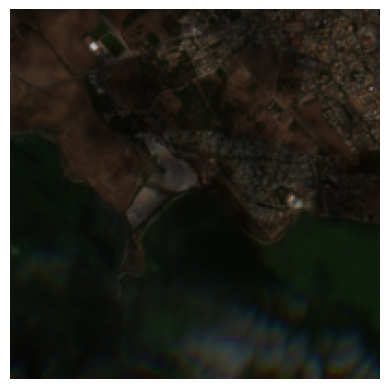

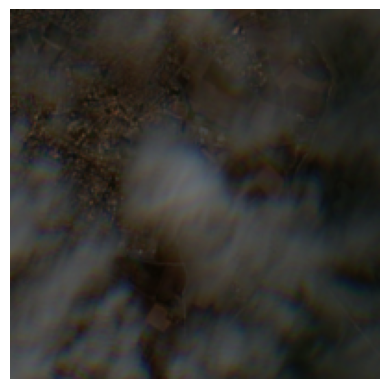

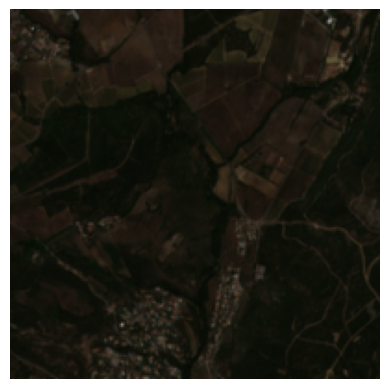

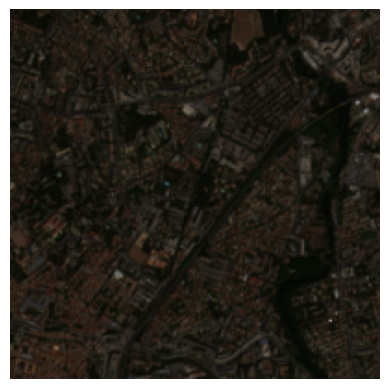

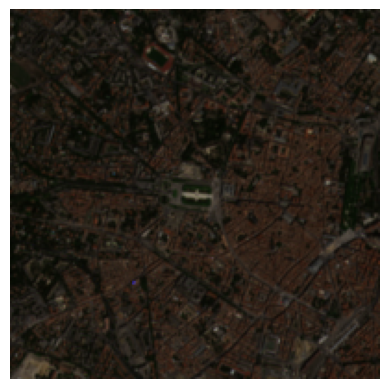

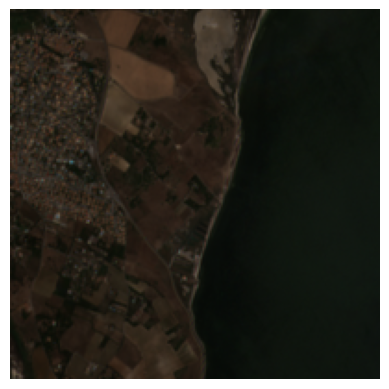

In [30]:
torch.manual_seed(1)
t1 = time()
dataset = Sentinel2(Path("../../../examples/micro_geolifeclef/dataset/sentinel2_raster_torch_geo"), split='train')
sampler = Sentinel2GeoSampler(dataset, size=2000, units=Units.CRS)
dataloader2 = DataLoader(dataset, sampler=sampler, batch_size=1)  # Can't use unbind_samples() but compatible with tuple return in RasterTorchGeoDataset (without any collate_fn which expects dictionnaries [at least stack_samples])
print(f'Execution time: {time()-t1} s')

for batch2 in dataloader2:
    sample = batch2[0][0], batch2[0][0]
    dataset.plot(sample[0])
    plt.axis("off")
    plt.show()

Execution time: 0.011418581008911133 s


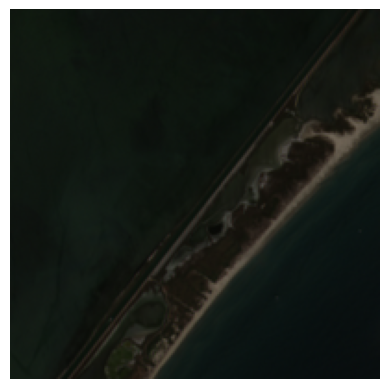

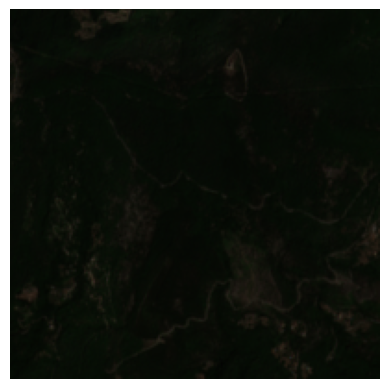

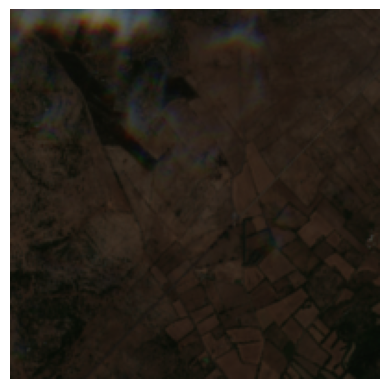

In [32]:
torch.manual_seed(10)
t2 = time()
dataset = Sentinel2(Path("../../../examples/micro_geolifeclef/dataset/sentinel2_raster_torch_geo"))
sampler = RandomGeoSampler(dataset, size=2000, length=3, units=Units.CRS)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=1, collate_fn=stack_samples)
print(f'Execution time: {time()-t2} s')
for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample['image'])
    plt.axis("off")
    plt.show()

For those who are curious, these are glaciers on Novaya Zemlya, Russia.

## Custom parameters

If you want to add custom parameters to the class, you can override the `__init__` method. For example, let's say you have imagery that can be automatically downloaded. The `RasterDataset` base class doesn't support this, but you could add support in your subclass. Simply copy the parameters from the base class and add a new `download` parameter.

In [14]:
class Downloadable(RasterDataset):
    def __init__(self, root, crs, res, transforms, cache, download=False):
        super().__init__(root, crs, res, transforms, cache)

        if download:
            # download the dataset
            ...

## Contributing

TorchGeo is an open source ecosystem built from the contributions of users like you. If your dataset might be useful for other users, please consider contributing it to TorchGeo! You'll need a bit of documentation and some testing before your dataset can be added, but it will be included in the next minor release for all users to enjoy. See the [Contributing](https://torchgeo.readthedocs.io/en/stable/user/contributing.html) guide to get started.